In [1]:
%matplotlib inline

#import datetime
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
#import plotly.plotly as py
import time
import math

from sklearn import neural_network
#from sklearn import linear_model
from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt

timeformat = "%Y-%m-%d %H:%M:%S"

In [2]:
code = 11
name = {1:"二林",2:"大里",3:"竹山",4:"西屯",5:"沙鹿",6:"忠明",7:"南投",8:"埔里",9:"彰化",10:"線西",11:"豐原"}
data = pd.read_csv("../data/central_reg/filted/%d.csv"%(code))
#data = data.rename(columns={"EL_PM25":"PM25"})
data = data[["datetime", "PM25"]]
print(name[code])

豐原


# Preprocessing

In [3]:
l, n = 24, 6
for i in range(l):
    data['last_' + str(i+1)] = data['PM25'].shift(1+i)
for i in range(n):
    data['next_' + str(i+1)] = data['PM25'].shift(-(1+i))

# Select feature

In [4]:
PM25 = ["PM25"]
exclude_cols = ['datetime']
last_cols = [f for f in data.columns.tolist() if 'last_' in f]
next_cols = [f for f in data.columns.tolist() if 'next_' in f]

# Train & Test Split

In [5]:
def train_test_split(dataframe):
    start = dataframe[data.datetime.values == '2016-01-01 00:00:00'].index[0]
    datatrain = dataframe[:start]
    datatest = dataframe[start:]
    feature_cols = exclude_cols + PM25 + last_cols + next_cols
    train = datatrain[feature_cols].dropna().reset_index(drop=True)
    test = datatest[feature_cols].dropna().reset_index(drop=True)
    X_train, X_test = train[PM25 + last_cols], test[PM25 + last_cols]
    return train, test

In [6]:
train, test = train_test_split(data)
X_train, X_test = train[PM25 + last_cols], test[PM25 + last_cols]
print("A Model:\n" + ", ".join(X_train.columns.tolist()))

A Model:
PM25, last_1, last_2, last_3, last_4, last_5, last_6, last_7, last_8, last_9, last_10, last_11, last_12, last_13, last_14, last_15, last_16, last_17, last_18, last_19, last_20, last_21, last_22, last_23, last_24


In [7]:
print("(%d,%d)"%(X_train.shape[0], X_test.shape[0]))

(52837,2791)


# Base Line

In [8]:
# Persistence Model
P_list = X_test["PM25"]
for i in range(n):
    P_rmse = sqrt(mean_squared_error(P_list, test['next_' + str(i+1)]))
    print("(%d) %f"%(i+1, round(P_rmse, 6)))

(1) 6.178029
(2) 8.567476
(3) 10.991218
(4) 11.839107
(5) 12.822968
(6) 13.720400


In [9]:
# Linear Model
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
for i in range(n):
    L = LinearRegression()
    L.fit(X_train, train['next_' + str(i+1)])
    L_list = L.predict(X_test)
    L_rmse = sqrt(mean_squared_error(L_list, test['next_' + str(i+1)]))
    print("(%d) %f"%(i+1, round(L_rmse, 6)))

(1) 6.760168
(2) 8.243450
(3) 10.031753
(4) 10.634929
(5) 11.204470
(6) 11.702312


# Rolling Windows Model

In [10]:
# n model for n period and fix window size
for i in range(n):
    MLP = neural_network.MLPRegressor()
    MLP.fit(X_train.iloc[:,range(l+1)], train["next_" + str(i+1)])
    X_preds = MLP.predict(X_test.iloc[:,range(l+1)])
    X_test = pd.concat([pd.DataFrame({"pred_" + str(i+1):X_preds}), X_test], axis=1)
    X_rmse = sqrt(mean_squared_error(X_test["pred_" + str(i+1)], test["next_" + str(i+1)]))
    print("(%d) %f"%(i+1, round(X_rmse, 6)))
    X_preds = MLP.predict(X_train.iloc[:,range(l+1)])
    X_train = pd.concat([pd.DataFrame({"pred_" + str(i+1):X_preds}), X_train], axis=1)


(1) 6.855244
(2) 8.279120
(3) 9.958177
(4) 10.523685
(5) 11.228509
(6) 11.663539


# Visualization

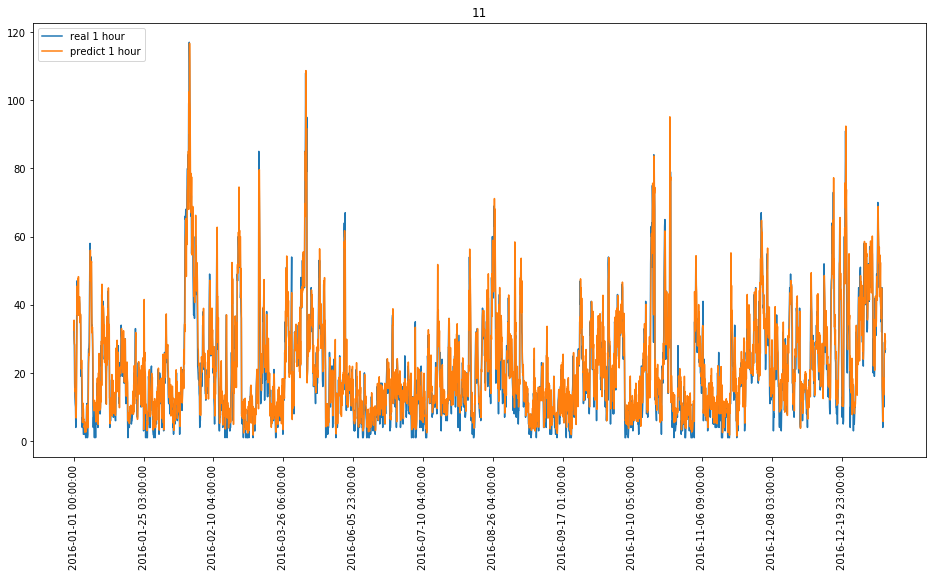

In [11]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
predict_hour = 1
size = len(test)
plt.title(code)
plt.rcParams['figure.figsize'] = [16.0, 8.0]
plt.plot(test["next_" + str(predict_hour)][-1*size:].tolist(), label='real %d hour'%(predict_hour))
#plt.plot(test["PM25"][-1*size:].tolist(), label='real time')
plt.plot(X_test["pred_" + str(predict_hour)][-1*size:].tolist(), label='predict %d hour'%(predict_hour))
plt.xticks(range(0, size, 240), test["datetime"][-1*size::240])
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

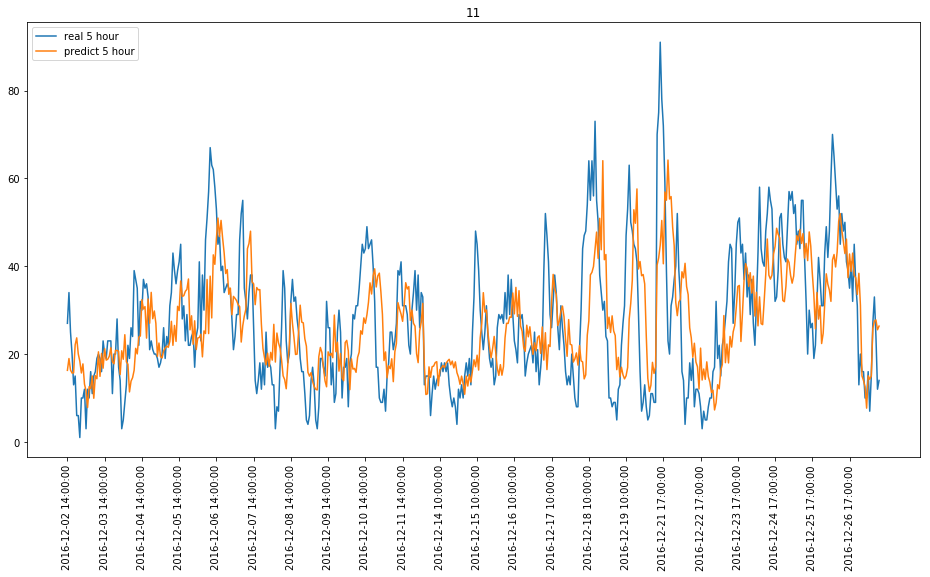

In [12]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
predict_hour = 5
m_start = test[test.datetime.values == '2016-12-02 14:00:00'].index[0]
size = len(test[m_start:])
plt.title(code)
plt.rcParams['figure.figsize'] = [16.0, 8.0]
plt.plot(test["next_" + str(predict_hour)][-1*size:].tolist(), label='real %d hour'%(predict_hour))
#plt.plot(test["PM25"][-1*size:].tolist(), label='real time')
plt.plot(X_test["pred_" + str(predict_hour)][-1*size:].tolist(), label='predict %d hour'%(predict_hour))
plt.xticks(range(0, size, 24), test["datetime"][-1*size::24])
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

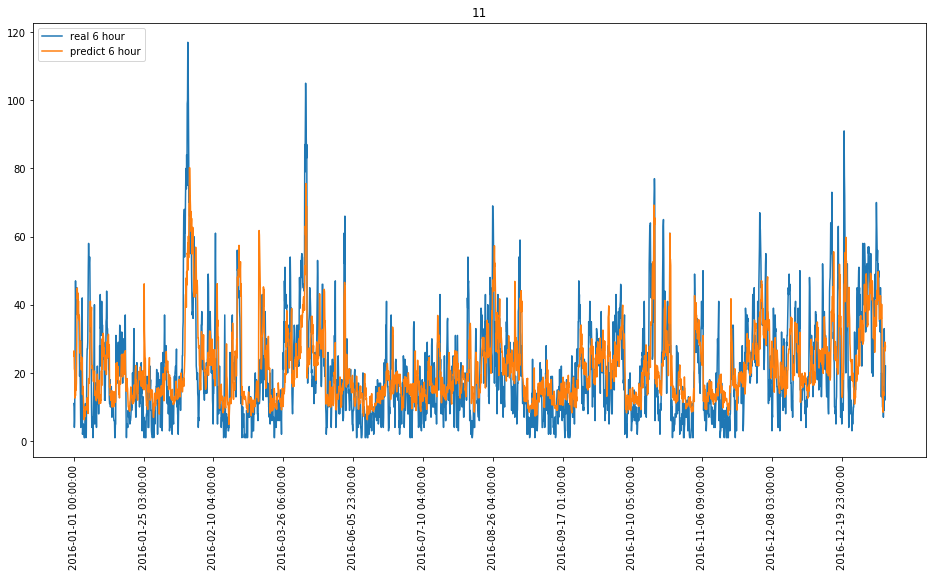

In [13]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
predict_hour = 6
size = len(test)
plt.title(code)
plt.rcParams['figure.figsize'] = [16.0, 8.0]
plt.plot(test["next_" + str(predict_hour)][-1*size:].tolist(), label='real %d hour'%(predict_hour))
#plt.plot(test["PM25"][-1*size:].tolist(), label='real time')
plt.plot(X_test["pred_" + str(predict_hour)][-1*size:].tolist(), label='predict %d hour'%(predict_hour))
plt.xticks(range(0, size, 240), test["datetime"][-1*size::240])
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

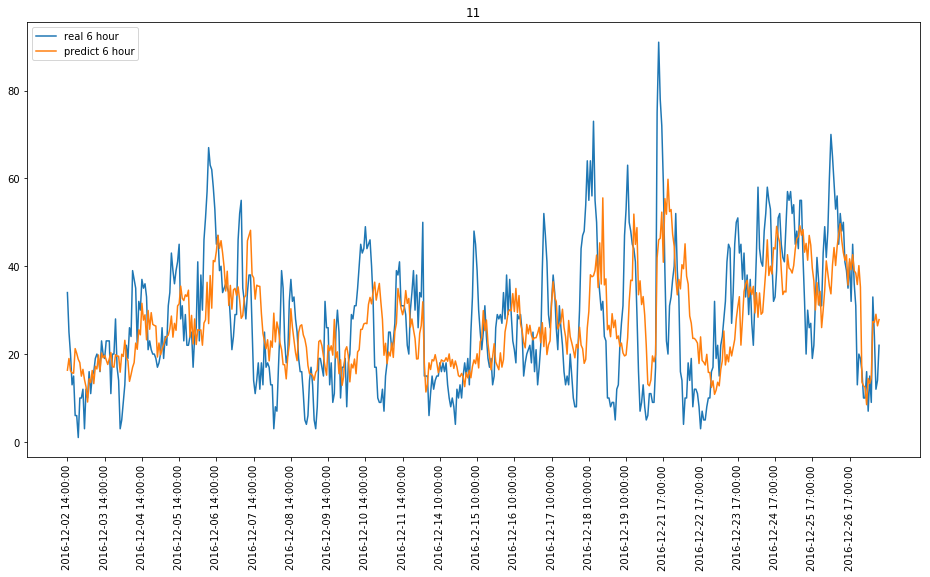

In [14]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
predict_hour = 6
m_start = test[test.datetime.values == '2016-12-02 14:00:00'].index[0]
size = len(test[m_start:])
plt.title(code)
plt.rcParams['figure.figsize'] = [16.0, 8.0]
plt.plot(test["next_" + str(predict_hour)][-1*size:].tolist(), label='real %d hour'%(predict_hour))
#plt.plot(test["PM25"][-1*size:].tolist(), label='real time')
plt.plot(X_test["pred_" + str(predict_hour)][-1*size:].tolist(), label='predict %d hour'%(predict_hour))
plt.xticks(range(0, size, 24), test["datetime"][-1*size::24])
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()